In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers


In [48]:
datagen = ImageDataGenerator (
                                   rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
            )

images_dir ='MaskData/'

In [49]:
# load the data using data generators
train_generator  =    datagen.flow_from_directory(
                             images_dir + 'Train',
                             seed=42,
                             target_size = (200,200),
                             batch_size =32 ,               
                             class_mode = 'binary',
                            )

test_generator = datagen.flow_from_directory(
                             images_dir + 'Test' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 32 ,               
                             class_mode = 'binary',
                            )

Validation_generator = datagen.flow_from_directory(
                             images_dir + 'Validation' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 32 ,               
                             class_mode = 'binary',
                            )

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [50]:
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(32,(3,3),input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [51]:
H = model.fit_generator(
                    train_generator ,
                    epochs = 15,
                    validation_data = Validation_generator)

Epoch 1/15
19/19 [==============================] - 56s 3s/step - loss: 2.2364 - accuracy: 0.5083 - val_loss: 0.6129 - val_accuracy: 0.5163
Epoch 2/15
19/19 [==============================] - 45s 2s/step - loss: 0.5360 - accuracy: 0.7667 - val_loss: 0.4998 - val_accuracy: 0.7516
Epoch 3/15
19/19 [==============================] - 43s 2s/step - loss: 0.4019 - accuracy: 0.8517 - val_loss: 0.5050 - val_accuracy: 0.7647
Epoch 4/15
19/19 [==============================] - 47s 2s/step - loss: 0.3984 - accuracy: 0.8600 - val_loss: 0.3688 - val_accuracy: 0.8399
Epoch 5/15
19/19 [==============================] - 47s 2s/step - loss: 0.3573 - accuracy: 0.8667 - val_loss: 0.3866 - val_accuracy: 0.8627
Epoch 6/15
19/19 [==============================] - 47s 2s/step - loss: 0.3632 - accuracy: 0.8400 - val_loss: 0.3933 - val_accuracy: 0.8497
Epoch 7/15
19/19 [==============================] - 47s 2s/step - loss: 0.3335 - accuracy: 0.8550 - val_loss: 0.4192 - val_accuracy: 0.8072
Epoch 8/15
19/19 [==

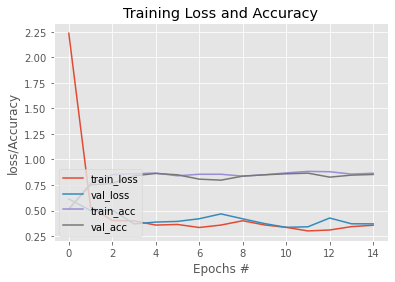

In [54]:
#plot the training loss and accuracy
from matplotlib import pyplot as plt
N = 15
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N) , H.history['loss'] , label ='train_loss')
plt.plot(np.arange(0,N) , H.history['val_loss'] , label ='val_loss')
plt.plot(np.arange(0,N) , H.history['accuracy'] , label ='train_acc')
plt.plot(np.arange(0,N) , H.history['val_accuracy'] , label ='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs #")
plt.ylabel("loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [55]:

import cv2 
face_clsfr=cv2.CascadeClassifier('haarscade_frontalface_default.xml')

In [60]:
labels_dict={0:'NO Mask',1:'Mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(200,200))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,200,200,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        #print(result)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()

In [61]:
from keras.preprocessing import image
test_image = image.load_img(images_dir +'Test/Mask/2260.png', target_size = (200,200,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
answer = model.predict_classes(test_image)
train_generator.class_indices
if result[0][0]==1:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)

unmask
